# Setting base for forcasting 

## In finance what do we forcast :
| Type                   | Example                        | ARIMA Use                                       |
| ---------------------- | ------------------------------ | ----------------------------------------------- |
| **Prices**             | Stock closing price, gold, oil | Predict short-term movement                     |
| **Returns**            | Daily log returns              | Forecast expected next-day return or volatility |
| **Risk Metrics**       | VaR or volatility series       | Forecast risk or exposure ahead                 |
| **Macroeconomic Data** | CPI, interest rates, GDP       | Forecast policy or inflation trends             |


Financial Time Series (like stock returns, prices, volatility) often change over time, which violates the statistical assumption of constant mean/varience

Most models (ARIMA, GARCH, regression etc) require stationarity to make meaningful forcasts. So we need to check and transform data before modelling 

- Stationarity means : mean is constant over time, varience is constant, co-varience depends only on lag h, not time 

- Types of Stationarity :
    - trend non-stationarity: long-term upward/downward movement 
    - seasonal non-stationarity: repeating patterns (eg: sales spike in dec)
    - varience non-stationarity: volitility changes over time 

- common test :
    - Augmented dickey-fuller(ADF): null hypothesis : data is non-stationary, if p<0.05 -> reject H<sub>0</sub> -> series is stationary 
    - KPSS : null hypothesis: data is stationary, if p<0.5 -> reject  H<sub>0</sub> -> series is non-stationary 
You use both - if ADF says statioanry and KPSS agress, good. if they disagree then the data may have trends or structural shifts 


In [15]:
import pandas as pd
import yfinance as yf 
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss

data = yf.download("AAPL", start="2020-01-01", end="2023-01-01")
data = data[["Close"]].rename(columns={'Close':'price'})
data['return'] = data['price'].pct_change().dropna()
data.head()

/var/folders/kr/gft6qzsx1pd7p6nqyq9g3wd00000gn/T/ipykernel_17519/2180956969.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start="2020-01-01", end="2023-01-01")
[*********************100%***********************]  1 of 1 completed


Price,price,return
Ticker,AAPL,
Date,,
2020-01-02,72.538528,NaN
2020-01-03,71.833298,-0.009722
2020-01-06,72.405670,0.007968
2020-01-07,72.065155,-0.004703
2020-01-08,73.224403,0.016086


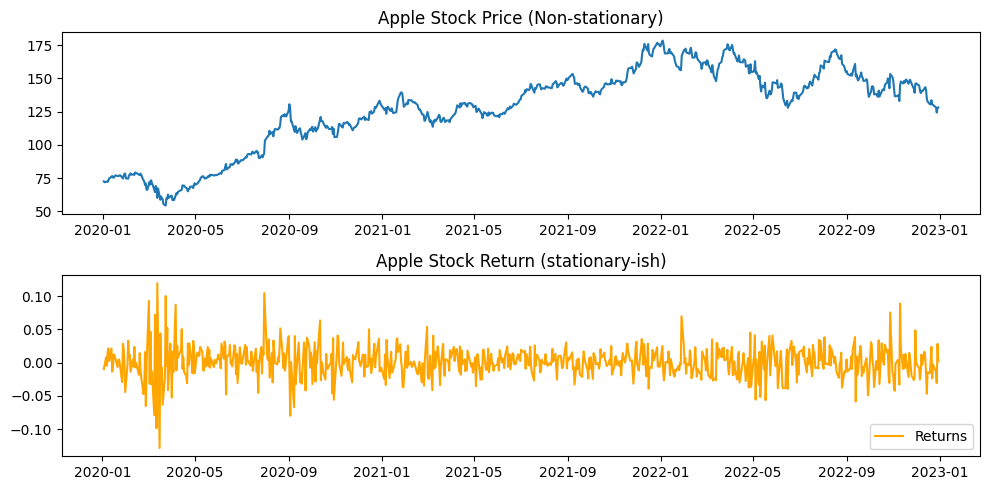

In [7]:
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(data['price'], label='Price')
plt.title("Apple Stock Price (Non-stationary)")

plt.subplot(2,1,2)
plt.plot(data['return'], color='orange', label='Returns')
plt.title("Apple Stock Return (stationary-ish)")
plt.legend()
plt.tight_layout()
plt.show()

Price keeps trending - mean/varience changes -> non-stationary

returns fluctuate around zero -> mean/varience constant -> stationary

In [8]:
def adf_test(series, name=''):
    result = adfuller(series.dropna())
    print(f"ADF Test for {name}")
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print(f'Critical Value {key}: {value}')
    if result[1] <= 0.05:
        print("Reject the null hypothesis - series is stationary")
    else:
        print("Fail to reject the null hypothesis - series is non-stationary")

adf_test(data['price'], 'Price')
adf_test(data['return'], 'Return')

ADF Test for Price
ADF Statistic: -1.8889078396850207
p-value: 0.33729706997239867
Critical Value 1%: -3.439052522969989
Critical Value 5%: -2.8653808299915013
Critical Value 10%: -2.5688152592363274
Fail to reject the null hypothesis - series is non-stationary
ADF Test for Return
ADF Statistic: -8.814456524606078
p-value: 1.951318207939903e-14
Critical Value 1%: -3.439146171679794
Critical Value 5%: -2.865422101274577
Critical Value 10%: -2.568837245865348
Reject the null hypothesis - series is stationary


In [9]:
def kpss_test(series, name=''):
    result = kpss(series.dropna(), regression='c', nlags="auto")    
    print(f"\nKPSS Test for {name}")
    print('KPSS Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[3].items():
        print(f'Critical Value {key}: {value}')
    if result[1] <= 0.05:
        print("Reject the null hypothesis - series is non-stationary")
    else:
        print("Fail to reject the null hypothesis - series is stationary")

kpss_test(data['price'], 'Price')
kpss_test(data['return'], 'Return')


KPSS Test for Price
KPSS Statistic: 3.3564677107329546
p-value: 0.01
Critical Value 10%: 0.347
Critical Value 5%: 0.463
Critical Value 2.5%: 0.574
Critical Value 1%: 0.739
Reject the null hypothesis - series is non-stationary

KPSS Test for Return
KPSS Statistic: 0.3271386227195826
p-value: 0.1
Critical Value 10%: 0.347
Critical Value 5%: 0.463
Critical Value 2.5%: 0.574
Critical Value 1%: 0.739
Fail to reject the null hypothesis - series is stationary


/var/folders/kr/gft6qzsx1pd7p6nqyq9g3wd00000gn/T/ipykernel_17519/51938663.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags="auto")
/var/folders/kr/gft6qzsx1pd7p6nqyq9g3wd00000gn/T/ipykernel_17519/51938663.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags="auto")


So, stock prices are non-stationary, but returns are stationary. That's why in modelling (ARIMA, GARCH, etc.) - we use returns, not raw prices.

---------

#### Why do we "difference' data ?

Most time series models assume stationarity. but stock prices aren't to fix that, we take the difference between consecutive observations, which removes the trend and stabilizes the mean. 

In [16]:
data['price_diff'] = data['price'].diff().dropna()
data[['price', 'price_diff']].head()

Price,price,price_diff
Ticker,AAPL,
Date,,
2020-01-02,72.538528,NaN
2020-01-03,71.833298,-0.705231
2020-01-06,72.405670,0.572372
2020-01-07,72.065155,-0.340515
2020-01-08,73.224403,1.159248


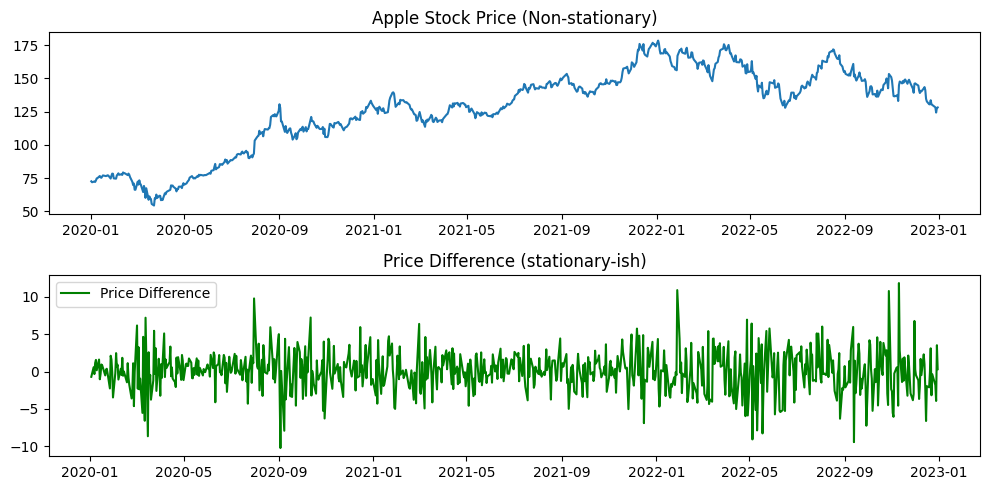

In [17]:
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(data['price'], label='Price')
plt.title("Apple Stock Price (Non-stationary)") 

plt.subplot(2,1,2)
plt.plot(data['price_diff'], color='green', label='Price Difference')
plt.title("Price Difference (stationary-ish)")
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
adf_test(data['price_diff'], 'Price Difference')
kpss_test(data['price_diff'], 'Price Difference')

ADF Test for Price Difference
ADF Statistic: -29.167878392100942
p-value: 0.0
Critical Value 1%: -3.439052522969989
Critical Value 5%: -2.8653808299915013
Critical Value 10%: -2.5688152592363274
Reject the null hypothesis - series is stationary

KPSS Test for Price Difference
KPSS Statistic: 0.22947958868380083
p-value: 0.1
Critical Value 10%: 0.347
Critical Value 5%: 0.463
Critical Value 2.5%: 0.574
Critical Value 1%: 0.739
Fail to reject the null hypothesis - series is stationary


/var/folders/kr/gft6qzsx1pd7p6nqyq9g3wd00000gn/T/ipykernel_17519/51938663.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags="auto")


So after one diffferencing step, the price series becomes stationary - similar to returns 

______

### Autocorrelation Analysis 

Once our series is stationary, the next step is to unerstand internal structure - in particular, how past influence the present. 

That's where autocorrelation and partial autocorrelation come in:
- ACF : correlation of the series with its own past values. Helps you detect overall lag dependence. 
- PACF : isolates the direct effect of a lag by removing influence of intermediate lags. 


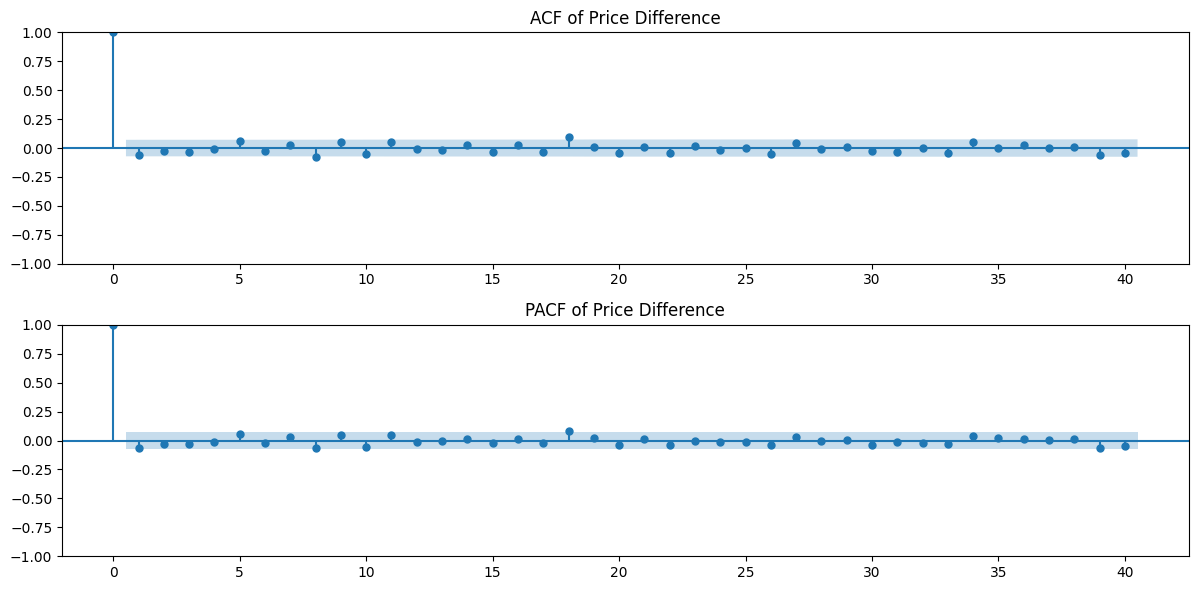

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plot_acf(data['price_diff'].dropna(), ax=plt.gca(), lags=40)
plt.title("ACF of Price Difference")     

plt.subplot(2,1,2)
plot_pacf(data['price_diff'].dropna(), ax=plt.gca(), lags=40)
plt.title("PACF of Price Difference")
plt.tight_layout()
plt.show()

This plot tells us few things which will be useful in ARIMA:
- If ACF spikes only at lag 1 -> strong short-term memory -> maybe MA(1)
- If PACF spikes at lag 1 -> autoregressive behavior -> maybe AR(1)

_____

### But what is ARIMA and what are p and q in it ?

ARIMA : AutoRegressive Integrated Moving Average

and it is defined by three parameters :
                ARIMA(p,d,q)
| Parameter | Meaning                                | What it captures                                               |
| --------- | -------------------------------------- | -------------------------------------------------------------- |
| **p**     | Number of **autoregressive (AR)** lags | How many past values influence the current one                 |
| **d**     | Degree of **differencing**             | How many times the series is differenced to make it stationary |
| **q**     | Number of **moving average (MA)** lags | How many past errors influence the current value               |

#### AR (Autoregressive part → p)

“Today’s value depends on past values.”

𝑦𝑡=𝑐+𝜙1𝑦𝑡−1+𝜙2𝑦𝑡−2+⋯+𝜖𝑡
- If only yesterday’s value matters → AR(1) → p = 1
- If last two days matter → AR(2) → p = 2

🔍 How to detect:
Look at the PACF plot — sharp cutoff after lag p indicates AR(p).

#### MA (Moving Average part → q)

“Today’s value depends on past forecast errors.”

𝑦𝑡=𝑐+𝜖𝑡+𝜃1𝜖𝑡−1+𝜃2𝜖𝑡−2+…

- If yesterday’s error matters → MA(1) → q = 1
- If last 3 errors matter → MA(3) → q = 3

🔍 How to detect:
Look at the ACF plot — sharp cutoff after lag q indicates MA(q).

#### d (Differencing → Stationarity)

Used to remove trend and stabilize mean.

𝑦𝑡′=𝑦𝑡−𝑦𝑡−1
	​
- If one differencing makes data stationary → d = 1

- If still trending → d = 2

💡 Example

If:

- PACF has a big spike at lag 1 → AR(1)
- ACF has two strong spikes (lags 1 and 2) → MA(2)
- You used one differencing → d = 1

Then your model is:
ARIMA(1,1,2)

#### Example (in English terms)

Let’s say we want to predict monthly sales.

AR (p):
“Sales this month depend on sales from the past few months.”
→ If p = 2, we’re looking at the last 2 months to predict this month.

I (d):
“We remove the trend (like steady growth) so that only fluctuations remain.”
→ Differencing means subtracting each value from the previous one.

MA (q):
“The current month’s sales are also affected by the errors made in predicting the previous months.”
→ If last month’s forecast was off by $100, the model adjusts for that.

/var/folders/kr/gft6qzsx1pd7p6nqyq9g3wd00000gn/T/ipykernel_17519/3602204536.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start="2020-01-01", end="2024-12-31")["Close"]
[*********************100%***********************]  1 of 1 completed


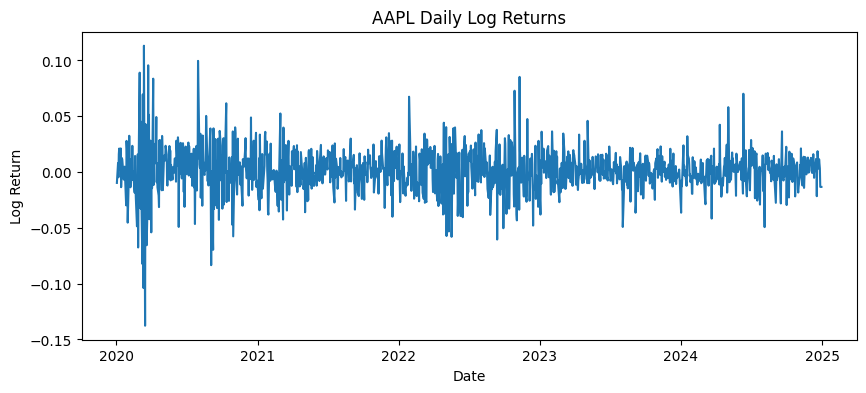

ADF Statistic: -11.2823
p-value: 0.0000
✅ The series is stationary (no differencing needed).


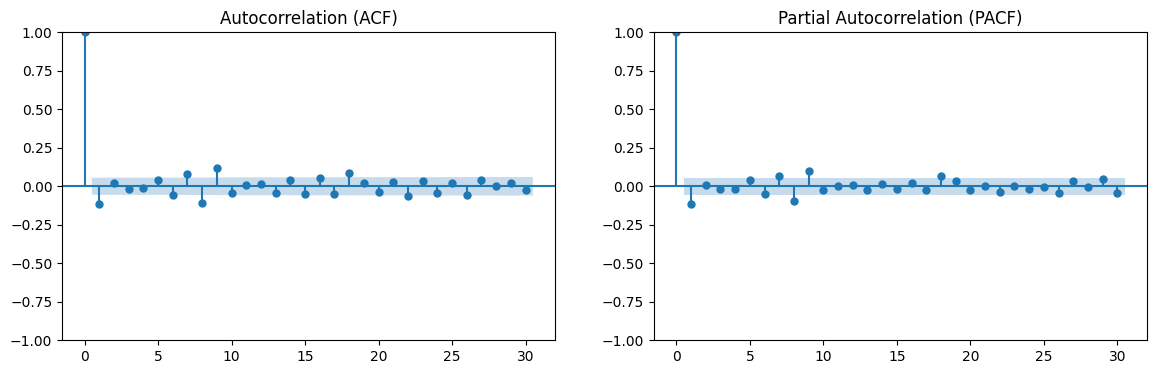

In [21]:
# --- Imports ---
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# --- Load Data ---
data = yf.download("AAPL", start="2020-01-01", end="2024-12-31")["Close"]

# --- Compute Log Returns ---
returns = np.log(data / data.shift(1)).dropna()

# --- Plot Returns ---
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.title("AAPL Daily Log Returns")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.show()

# --- Augmented Dickey-Fuller Test (Stationarity) ---
adf_result = adfuller(returns)
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")

if adf_result[1] < 0.05:
    print("✅ The series is stationary (no differencing needed).")
else:
    print("⚠️ The series is non-stationary (may need differencing).")

# --- Plot ACF & PACF ---
fig, axes = plt.subplots(1, 2, figsize=(14,4))
plot_acf(returns, ax=axes[0], lags=30)
plot_pacf(returns, ax=axes[1], lags=30, method="ywm")
axes[0].set_title("Autocorrelation (ACF)")
axes[1].set_title("Partial Autocorrelation (PACF)")
plt.show()


### Typical Observations 
| Plot Observation                  | Interpretation                |
| --------------------------------- | ----------------------------- |
| ACF tails off quickly after lag 1 | Suggests MA(1)                |
| PACF tails off gradually          | Suggests AR term not dominant |
| ADF test p < 0.05                 | Stationary → `d = 0`          |

<span style="color:lightblue;">Hence, a possible model: ARIMA(0, 0, 1) or ARIMA(1, 0, 1)</span>